# Introduction

In this analysis, we examine the results of an A/B test conducted by a fast-food chain to determine the most effective marketing strategy for promoting a new menu item. The fast-food chain is undecided between three potential promotional campaigns, and the aim of the test is to identify which of these campaigns has the greatest positive impact on sales. Each campaign has been implemented at selected locations in randomly chosen markets, and weekly sales data of the new item has been collected over a four-week period.

The goal of this analysis is to evaluate the results of the A/B test and determine which marketing strategy maximizes sales for the new product. Ultimately, this insight will guide the fast-food chain in deciding which promotional strategy to scale across its locations.

## Analysis Objectives
* **Goal and Metric:** The objective of the A/B test is to identify which of the three campaigns drives more revenue for the new item. For that, I'll be comparing the difference for the mean in the feature `SalesInThousands` for each group.

* **Data Preparation and Key Insights:** Aggregate and prepare the data, reporting key information like sample size and group proportions.

* **Statistical Testing:** Conduct statistical tests to compare sales across campaigns, explaining each test choice.

* **Expected Effect:** Since marketing campaigns usually report an increase of 3 to 7% in sales, we will aim for a 5% difference in sales to determine that one campaign outperforms the others. 

* **Interpret Results and Recommend:** Estimate treatment effects, report confidence intervals and p-values, and provide a data-driven recommendation on the best-performing campaign. Visualizations will be used to illustrate group differences and confidence levels.

By the end, this analysis will provide a clear recommendation on which marketing strategy to adopt, based on both statistical significance and practical relevance to sales goals.

## Import libraries and dataset

I'll start by importing the libraries I'll be using and doing a small exploration on the data.

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import scipy 
from scipy.stats import norm
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import scikit_posthocs as sp

In [26]:
data = pd.read_csv('WA_Marketing-Campaign.csv')
data.head()

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33.73
1,1,Medium,1,4,3,2,35.67
2,1,Medium,1,4,3,3,29.03
3,1,Medium,1,4,3,4,39.25
4,1,Medium,2,5,2,1,27.81


In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MarketID          548 non-null    int64  
 1   MarketSize        548 non-null    object 
 2   LocationID        548 non-null    int64  
 3   AgeOfStore        548 non-null    int64  
 4   Promotion         548 non-null    int64  
 5   week              548 non-null    int64  
 6   SalesInThousands  548 non-null    float64
dtypes: float64(1), int64(5), object(1)
memory usage: 30.1+ KB


The dataset does not contain null values. 

In [28]:
to_categories = ['MarketID', 'LocationID', 'week']
for col in to_categories:
    data[col] = data[col].astype('object')

In [29]:
data.describe()

,AgeOfStore,Promotion,SalesInThousands
count,548.000000,548.000000,548.000000
mean,8.503650,2.029197,53.466204
std,6.638345,0.810729,16.755216
min,1.000000,1.000000,17.340000
25%,4.000000,1.000000,42.545000
50%,7.000000,2.000000,50.200000
75%,12.000000,3.000000,60.477500
max,28.000000,3.000000,99.650000


In [30]:
data.describe(exclude=[np.number])

,MarketID,MarketSize,LocationID,week
count,548,548,548,548
unique,10,3,137,4
top,3,Medium,1,1
freq,88,320,4,137


`SalesInThousands` represents the weekly sales revenue generated by the new menu item at each location during the length of the experiment. This metric measures progress toward the goal by providing quantifiable data on how effectively each marketing campaign drives sales. By analysing and comparing this metric across different promotional strategies, we can determine which campaign leads to the highest sales. 

Let's have a look on how each promotion performed during the test in total and on average:

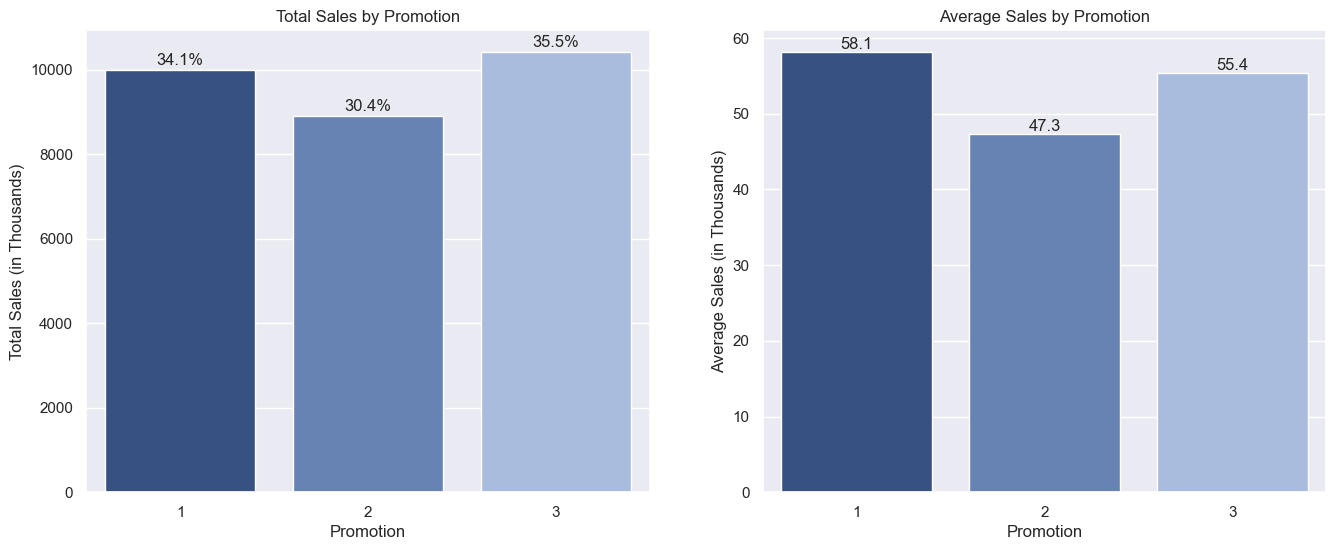

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

custom_palette = ["#2A4D8F", "#5A80C0", "#A2B9E5"]

sales_sum_by_promotion = data.groupby("Promotion")["SalesInThousands"].sum().reset_index()
sns.barplot(data=sales_sum_by_promotion, x='Promotion', hue="Promotion", y="SalesInThousands", 
            palette=custom_palette, ax=ax[0], legend=False)
ax[0].set_xlabel("Promotion")
ax[0].set_ylabel("Total Sales (in Thousands)")
ax[0].set_title("Total Sales by Promotion")

total_sales = sales_sum_by_promotion["SalesInThousands"].sum()
for index, row in sales_sum_by_promotion.iterrows():
    percentage = (row["SalesInThousands"] / total_sales) * 100
    ax[0].text(index, row["SalesInThousands"] + 50, f'{percentage:.1f}%', ha='center', va='bottom')


sales_avg_by_promotion = data.groupby("Promotion")["SalesInThousands"].mean().reset_index()
sns.barplot(data=sales_avg_by_promotion, x='Promotion', hue="Promotion", y="SalesInThousands", 
            palette=custom_palette, ax=ax[1], legend=False)
ax[1].set_xlabel("Promotion")
ax[1].set_ylabel("Average Sales (in Thousands)")
ax[1].set_title("Average Sales by Promotion")

avg_sales = sales_avg_by_promotion["SalesInThousands"]
for index, row in sales_avg_by_promotion.iterrows():
    #percentage = (row["SalesInThousands"] / total_sales) * 100
    ax[1].text(index, row["SalesInThousands"], f'{row["SalesInThousands"]:.1f}', ha='center', va='bottom')

plt.show()

While looking at the totals may indicat that promotion 3 drives more revenue, the average amount of the sales highlights that is actually promotion 1 the one having a higher impact on sales. In the tests I'll be validating if this difference is actually significant. 

Now, I'll move to do some sanity checks, to confirm that the experiment was well designed and the rest of the features are evenly distributed across the promotions and well represented. The variables I'm going to focus for this test are:
* Number of different locations (LocationID): verifying that each group has a similar number of different restaurants.
* MarketIDs: there are 10 different market id's, I'll verify that these are evenly represented in each promotion.
* Market Size: as with the Market ids, I'll be checking that all market sizes have a similar distribution across promotions.

If the result of the above tests is possitive, we can proceed to analyze the results of the test and trust its results. 

# Sanity checks

To be sure that the experiment was well designed it's essential to confirm that the randomization process hasn't unintentionally created biases across groups for key variables. The Chi-squared test can help in verifying that that the variables are distributed similarly across groups, suggesting effective randomization. 

The hypothesis of the test will be the following ones:

* $H_0$: Equal distribution of variables within promotions
* $H_a$: The distribution of the variables is different within promotions

## LocationID

In [41]:
# I'll be counting the number of unique LocationIDs within each Promotion group
location_counts = data.groupby('Promotion')['LocationID'].nunique()
print("Unique LocationID count by Promotion:\n", location_counts)

Unique LocationID count by Promotion:
 Promotion
1    43
2    47
3    47
Name: LocationID, dtype: int64


Promotion number 1 was assigned with less restaurants, that's why the total revenue was higher for promotion 3.

In [9]:
freq_observed = location_counts.values / location_counts.sum()
freq_expected = np.array([1/3] * 3)

pd.DataFrame(
    data=[freq_observed, freq_expected],
    index=['observed', 'expected'],
    columns=['promotion1', 'promotion2', 'promotion3']
)

,promotion1,promotion2,promotion3
observed,0.313869,0.343066,0.343066
expected,0.333333,0.333333,0.333333


In [10]:
# Chi-Square test
result = scipy.stats.chisquare(f_obs=freq_observed, f_exp=freq_expected)
statistic = float(result.statistic)
p_value = float(result.pvalue)

print(f"Chi-Square Statistic: {statistic:.4f}")
print(f"p-value: {p_value:.4f}")

Chi-Square Statistic: 0.0017
p-value: 0.9991


## MarketID

In [11]:
# Calculate the overall MarketID proportion
data_marketid = data['MarketID'].value_counts() / data.shape[0]
data_marketid = data_marketid.reset_index()
data_marketid.columns = ['MarketID', 'proportion']

promotion1 = data.loc[data['Promotion']==1]
promotion2 = data.loc[data['Promotion']==2]
promotion3 = data.loc[data['Promotion']==3]

# Loop through each promotion dataset and merge proportions
for i, promotion in enumerate([promotion1, promotion2, promotion3], start=1):
    promo_marketid = promotion['MarketID'].value_counts() / promotion.shape[0]
    promo_marketid = promo_marketid.reset_index()
    promo_marketid.columns = ['MarketID', f'proportion_p{i}']
    data_marketid = pd.merge(data_marketid, promo_marketid, on='MarketID', how='left').fillna(0)

# Set MarketID as the index and sort the DataFrame
data_marketid = data_marketid.set_index('MarketID').sort_index()

data_marketid


,proportion,proportion_p1,proportion_p2,proportion_p3
MarketID,,,,
1,0.094891,0.116279,0.106383,0.063830
2,0.043796,0.023256,0.000000,0.106383
3,0.160584,0.162791,0.127660,0.191489
4,0.065693,0.093023,0.085106,0.021277
5,0.109489,0.046512,0.170213,0.106383
6,0.109489,0.116279,0.127660,0.085106
7,0.109489,0.093023,0.085106,0.148936
8,0.087591,0.116279,0.042553,0.106383
9,0.072993,0.069767,0.042553,0.106383


In [12]:
for i, p in enumerate(['proportion_p1', 'proportion_p2', 'proportion_p3']):
    freq_observed = data_marketid.loc[:, p].values
    freq_expected = data_marketid.loc[:, 'proportion'].values

    result = scipy.stats.chisquare(f_obs=freq_observed, f_exp=freq_expected)
    statistic = float(result.statistic)
    p_value = float(result.pvalue)
    
    print(f"Results for the proportion of the market id in promotion {i+1}")
    print(f"Chi-Square Statistic: {statistic:.4f}, P-Value: {p_value:.4f}\n")
    

Results for the proportion of the market id in promotion 1
Chi-Square Statistic: 0.0764, P-Value: 1.0000

Results for the proportion of the market id in promotion 2
Chi-Square Statistic: 0.1662, P-Value: 1.0000

Results for the proportion of the market id in promotion 3
Chi-Square Statistic: 0.2209, P-Value: 1.0000



## Market Size

In [13]:
# Calculate the overall MarketID proportion
data_marketsize = data['MarketSize'].value_counts() / data.shape[0]
data_marketsize = data_marketsize.reset_index()
data_marketsize.columns = ['MarketSize', 'proportion']

# Loop through each promotion dataset and merge proportions
for i, promotion in enumerate([promotion1, promotion2, promotion3], start=1):
    promo_marketsize = promotion['MarketSize'].value_counts() / promotion.shape[0]
    promo_marketsize = promo_marketsize.reset_index()
    promo_marketsize.columns = ['MarketSize', f'proportion_p{i}']
    data_marketsize = pd.merge(data_marketsize, promo_marketsize, on='MarketSize', how='left').fillna(0)

# Set MarketID as the index and sort the DataFrame
data_marketsize = data_marketsize.set_index('MarketSize')

data_marketsize

,proportion,proportion_p1,proportion_p2,proportion_p3
MarketSize,,,,
Medium,0.583942,0.558140,0.574468,0.617021
Large,0.306569,0.325581,0.340426,0.255319
Small,0.109489,0.116279,0.085106,0.127660


In [14]:
for i, p in enumerate(['proportion_p1', 'proportion_p2', 'proportion_p3']):
    freq_observed = data_marketsize.loc[:, p].values
    freq_expected = data_marketsize.loc[:, 'proportion'].values

    result = scipy.stats.chisquare(f_obs=freq_observed, f_exp=freq_expected)
    statistic = float(result.statistic)
    p_value = float(result.pvalue)
    
    print(f"Results for the proportion of the market size in the promotion {i+1}")
    print(f"Chi-Square Statistic: {statistic:.4f}, p-value: {p_value:.4f}\n")
    

Results for the proportion of the market size in the promotion 1
Chi-Square Statistic: 0.0027, p-value: 0.9986

Results for the proportion of the market size in the promotion 2
Chi-Square Statistic: 0.0093, p-value: 0.9953

Results for the proportion of the market size in the promotion 3
Chi-Square Statistic: 0.0135, p-value: 0.9933



## Summary

The following table summarizes the obtained p-values for all the sanity checks:
|    p- values   | all promotions | promotion 1 | promotion 2 | promotion 3 |
|----------------|---------------|-------------|-------------|-------------|
| **LocationID** | 0.9991        |             |             |             |
| **MarketID**   |               | 1           | 1           | 1           |
| **MarketSize** |               | 0.9986      | 0.9953      | 0.9933      |

All of them are well above the significance level of 5% which indicates that the differences observed in the data is due to randomness and we can conclude that the experiment is well designed. 

# Confidence intervals for the mean of the sales
I'll give the 95% confidence interval for the average of the sales in each promotion.

In [42]:
promotion_1 = data[data['Promotion'] == 1]
promotion_2 = data[data['Promotion'] == 2]
promotion_3 = data[data['Promotion'] == 3]


for i in range(1, 4):
    promotion = data[data['Promotion'] == i]
    mu = np.mean(promotion.SalesInThousands)
    n = promotion.shape[0]
    std = np.std(promotion.SalesInThousands, ddof=1)

    z_mult = scipy.stats.norm.ppf(q=0.975)
    
    lb = mu - z_mult * std / np.sqrt(n)
    ub = mu + z_mult * std / np.sqrt(n)
    print(f"95% CI for the mean of sales in promotion {i} is: ({lb:.2f}, {ub:.2f})")


95% CI for the mean of sales in promotion 1 is: (55.63, 60.57)
95% CI for the mean of sales in promotion 2 is: (45.17, 49.49)
95% CI for the mean of sales in promotion 3 is: (52.97, 57.76)


| Promotion | Lower Bound | Upper Bound |
|-------------|-----------|-------------|
| Promotion 1 | 55.63     | 60.57       |
| Promotion 2 | 45.17     | 49.49       |
| Promotion 3 | 52.97     | 57.76       |

Looking at the 95% confidence intervals, we can see that there's no overlap between Promotion 2 and the other two promotions. This suggests that Promotion 2 has significantly lower performance compared to Promotions 1 and 3.

However, the confidence intervals for Promotions 1 and 3 do overlap in the range of 55.63 to 57.76. While Promotion 1 appears to outperform Promotion 3 at first glance, the overlapping confidence intervals indicate that we cannot definitively conclude that one promotion is significantly better than the other at the 95% confidence level.

# Tests

In order to see if there's a difference in the revenue obtained by each of the promotions I will be using an ANOVA (Analysis Of the Variation) test, this is the statistical procedure that tests for a statistically significant difference among the different groups.

## Assumptions

Before proceeding with the ANOVA test, we have to verify the following assumptions:
* **Independence:** The samples are independend of each other.
* **Normality:** Data in each group is approximately normally distributed.
* **Homogeneity of Variance:** The variances in each group are similar.

### Independence

Because the data consist of repeated measurements from the same locations over time, the independence assumption required is not fulfilled. In order to achieve it, we need to aggregate the sales by location to obtain a single measure of the sales per venue over the four weeks.

I'll get the mean value of the sales within the four weeks of the experiment. The reason behind using the mean over the sum is that the mean provides a per-week average, which is useful for understanding typical performance and helps us flatten unfrequent spikes that may occur. 

In [15]:
agg_data = data.groupby(['LocationID','MarketID', 'MarketSize', 'AgeOfStore', 'Promotion'])['SalesInThousands'].agg(
    MeanSalesInThousands = 'mean'
).reset_index()

agg_data.head()

,LocationID,MarketID,MarketSize,AgeOfStore,Promotion,MeanSalesInThousands
0,1,1,Medium,4,3,34.4200
1,2,1,Medium,5,2,29.5450
2,3,1,Medium,12,1,40.6800
3,4,1,Medium,1,2,33.7075
4,5,1,Medium,10,2,29.0025


### Normality

Let's check normality of the objective variable.

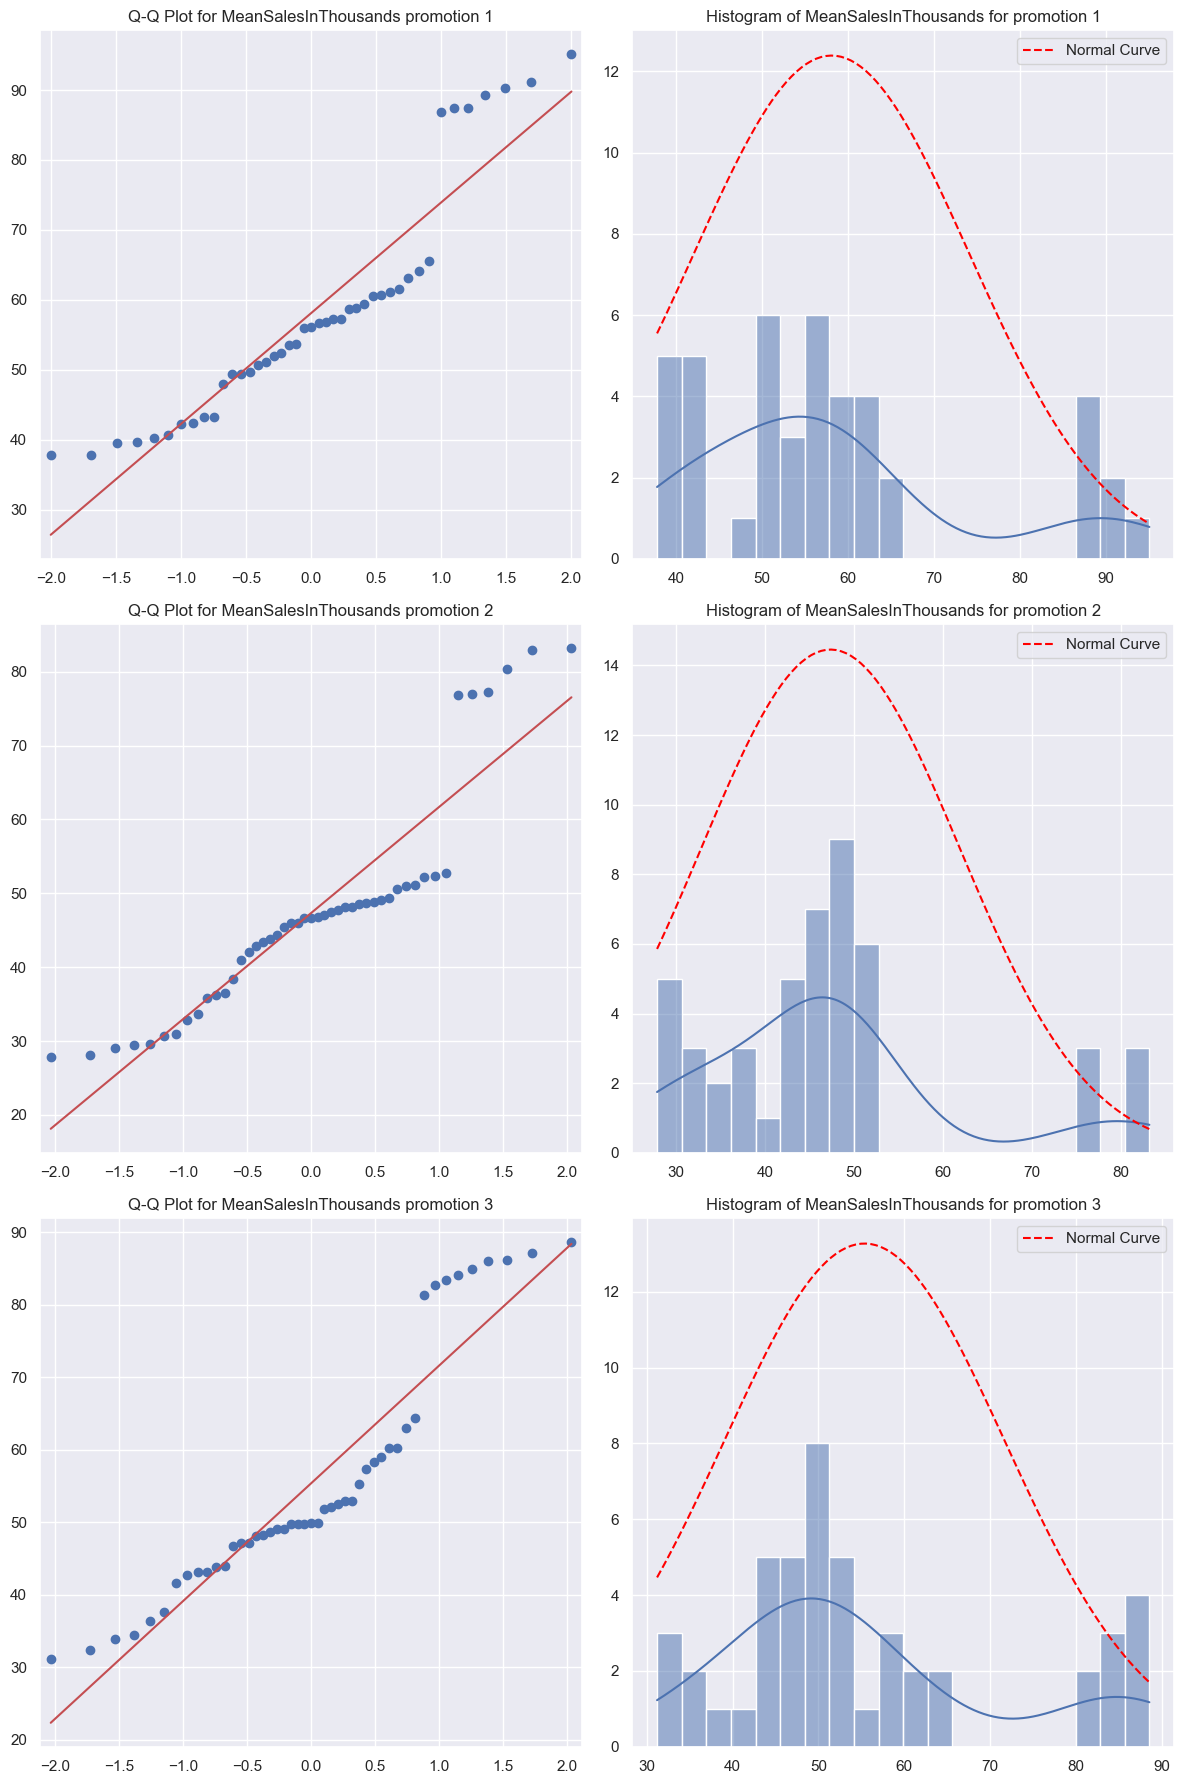

In [16]:
fig, ax = plt.subplots(3, 2, figsize=(12, 18))

for p in [1, 2, 3]:
    # Q-Q Plot
    qqplot(np.array(agg_data.loc[(agg_data['Promotion']==p), "MeanSalesInThousands"]), line="s", ax=ax[p-1, 0])
    ax[p-1,0].set_title(f"Q-Q Plot for MeanSalesInThousands promotion {p}")
    ax[p-1,0].set_xlabel("")
    ax[p-1,0].set_ylabel("")
    
    # Histogram 
    sns.histplot(agg_data.loc[(agg_data['Promotion']==p), "MeanSalesInThousands"], ax=ax[p-1, 1], bins=20, kde=True)
    ax[p-1,1].set_title(f"Histogram of MeanSalesInThousands for promotion {p}")
    ax[p-1,1].set_xlabel("")
    ax[p-1,1].set_ylabel("")
    
    # Normal distribution curve to compare with the histogram
    promotion = agg_data.loc[(agg_data['Promotion']==p), "MeanSalesInThousands"]
    mean = promotion.mean()
    std_dev = promotion.std()
    x_min = min(promotion)
    x_max = max(promotion)
    x = np.linspace(x_min, x_max, 100)
    ax[p-1, 1].plot(x, norm.pdf(x, mean, std_dev) * len(promotion) * (x[1] - x[0]) * 20, color="red", linestyle="--", label="Normal Curve")
    ax[p-1, 1].legend()

plt.tight_layout()
plt.show()

Based on the Q-Q plots for each promotion group, the data points deviate from the red line, indicating that the distributions of `MeanSalesInThousands` do not perfectly follow a normal distribution. The histograms further illustrate that none of the promotion groups show a clear normal distribution pattern. Instead, each distribution exhibits some degree of skewness and possible outliers on the right-hand side, with a few groups even showing characteristics of a potential bi-modal distribution.

This deviation from normality technically violates ANOVA’s assumption of normally distributed data within groups. However, with larger sample sizes (generally greater than 30), ANOVA can be robust to moderate deviations from normality due to the Central Limit Theorem. Given our sample sizes of 43, 47, and 47 observations for each group, we can reasonably proceed with the ANOVA, acknowledging that minor deviations from normality should not substantially impact the results.

### Homogeneity of Variance

Lastly, ANOVA assumes that the groups being compared have similar levels of variability, if this assumption is violated, the results of the ANOVA test may be unreliable. To check whether the variances within the promotion groups are equal or differ significantly, I'll be using Levene's Test, which tests the following hypotheses:

* $H_0$: The variances across groups are equal.
* $H_a$: At leas one group has a variance significantly different from the others.

There are two versions of Levene's test:
1. Mean-based Levene's Test: Uses the mean of each group to calculate deviations.
2. Median-based Levene's Test: Uses the median of each group, which is more robust to non-normal data or when outliers are present. 

In [17]:
for measure in ['mean', 'median']:
    test_stat, pvalue = scipy.stats.levene(agg_data.loc[agg_data["Promotion"] == 1, "MeanSalesInThousands"],
                                           agg_data.loc[agg_data["Promotion"] == 2, "MeanSalesInThousands"],
                                           agg_data.loc[agg_data["Promotion"] == 3, "MeanSalesInThousands"],
                                           center=measure
                                          )
    
    print(f"Levene's test for the {measure}\nTest Stat = {test_stat:.4f}, p-value = {pvalue:.4f}\n")

Levene's test for the mean
Test Stat = 1.0291, p-value = 0.3601

Levene's test for the median
Test Stat = 0.4682, p-value = 0.6272



Both p-values are greater than the typical significance level of 0.05, therefore we can assume that the variances between the groups are equal and proceed with the ANOVA test. 

## ANOVA Test 

The ANOVA (Analysis of Variance) test is a statistical method used to determine if there are statistically significant differences between the means of three or more independent groups. It tests whether any of the group means are different from each other, which is useful when comparing multiple groups to see if at least one differs in a meaningful way.

In our case, the hypothesis that we'll be testing with ANOVA will be the following:
* $H_0: \mu_1 = \mu_2 = \mu_3$ 
* $H_a: \mu_1 \neq \mu_2 \neq \mu_3$

Where $\mu$ is the mean revenue of each promotion

In [18]:
t_stat, p_val = scipy.stats.kruskal(agg_data.loc[agg_data['Promotion'] == 1, "MeanSalesInThousands"],
                                    agg_data.loc[agg_data['Promotion'] == 2, "MeanSalesInThousands"],
                                    agg_data.loc[agg_data['Promotion'] == 3, "MeanSalesInThousands"])
print(f"t statistic = {t_stat:.4f}, p-value = {p_val:.4f}")

t statistic = 17.3274, p-value = 0.0002


The p-value is very low (much lower than 0.05), meaning that we can reject the null hypothesis because there's an actual difference between the revenue generated by each promotion. 

ANOVA does not tell specifically which one of the groups is different so we need to perform another tests to identify specific differences. Usually, if ANOVA finds significant differences between the groups being compared, the next step is to perform a Tukey's HSD test to determine specifically which groups differs from each other. 

## Tukey's HSD Test

The Tukey's HSD (Honestly Significant Difference) test is a post-hoc analysis used after an ANOVA test to determine which specific pairs of groups have statistically significant differences in their means. It is used when you have three or more groups and want to find out if there are any pairwise differences among them.

The null hypothesis for this test states that there's no significant difference in the mean revenue between each pair of promotion groups, while the alternative states that there's a significant difference between at least one pair of pormotion groups. 
* $H_0: \mu_i = \mu_j$ 
* $H_a: \mu_i \neq \mu_j$

For each pair of promotions *i* and *j*

In [19]:
tukey_result = pairwise_tukeyhsd(endog=agg_data['MeanSalesInThousands'],
                                 groups=agg_data['Promotion'],
                                 alpha=0.05)

print(tukey_result)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     1      2 -10.7696  0.004 -18.5951  -2.944   True
     1      3  -2.7345 0.6862 -10.5601   5.091  False
     2      3   8.0351 0.0371   0.3854 15.6847   True
-----------------------------------------------------


We can also see how the values changed over the weeks of the experiment:

In [20]:
for i in range(1, 5):
    data_i = data[data['week'] <= i]
    
    data_i = data_i.groupby(['LocationID','MarketID', 'MarketSize', 'AgeOfStore', 'Promotion'])['SalesInThousands'].agg(
        MeanSalesInThousands = 'mean'
    ).reset_index()

    result = pairwise_tukeyhsd(endog=data_i['MeanSalesInThousands'],
                               groups=data_i['Promotion'],
                               alpha=0.05)
    
    print(f"Week {i}:\n {result}\n")

Week 1:
  Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     1      2 -10.5142 0.0084 -18.7571 -2.2713   True
     1      3  -2.4682 0.7582 -10.7111  5.7746  False
     2      3    8.046 0.0504  -0.0117 16.1036  False
-----------------------------------------------------

Week 2:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     1      2  -9.9306 0.0087 -17.753 -2.1082   True
     1      3  -1.7243 0.8605 -9.5467  6.0981  False
     2      3   8.2063 0.0323  0.5597 15.8529   True
----------------------------------------------------

Week 3:
  Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     1      2 -10.3046 0.0062 -18.1328 -2.4764   True
     1

Based on the above result, we can safely say that promotions 1 and 3 outperform promotion 2 but we could not state that they significantly differ from each other. 

The normality check highlighted the presence of outliers on the right side of all distributions, indicating a departure from normality. Consequently, the mean, which is susceptible to outliers, may not be the most suitable measure of central tendency. The median, on the other hand, is less affected by extreme values, providing a more accurate representation of the central tendency for each group. Let's see the differences for the median within the groups:

## Kruskal-Wallis Test
Another useful test for this case would be the Kruskal-Walllis test, which is a non-parametric statistical test used to compare the medians of three or more independent groups. Unlike ANOVA, it does not assume normality or equal variances, making it a good alternative when these assumptions are not met. In this case, we can use it to compare the medians of revenue across the three promotions.

The hypothesis contrasted in the test are:
* $H_0: \beta_1 = \beta_2 = \beta_3$  There is no difference in the central tendency (median) of the groups
* $H_a: \beta_1 \neq \beta_2 \neq \beta_3$  At least one group differs in terms of its median.

Where $\beta$ here stands for the median value of each group.

In [21]:
agg_data.groupby('Promotion')['MeanSalesInThousands'].agg(MedianSales="median", Size='size')

,MedianSales,Size
Promotion,,
1,56.0750,43
2,46.6550,47
3,49.8525,47


In [22]:
group1 = agg_data[agg_data['Promotion'] == 1]['MeanSalesInThousands']
group2 = agg_data[agg_data['Promotion'] == 2]['MeanSalesInThousands']
group3 = agg_data[agg_data['Promotion'] == 3]['MeanSalesInThousands']

stat, p_value = scipy.stats.kruskal(group1, group2, group3)

print(f"Kruskal-Wallis Test Statistic: {stat}")
print(f"P-value: {p_value}")

Kruskal-Wallis Test Statistic: 17.327374531871044
P-value: 0.00017274617006801912


The extremely low p-value obtained indicates a statistically significant difference in the medians of revenue among the promotions, meaning that at least one promotion differs in its effect on revenue. As with ANOVA, this test does not tell which one differs, so a Post-Hoc pairwise analysis is needed. 

## Dunn's Test

When the Kruskal-Wallis test indicates a significant difference among three or more groups, Dunn's test helps identify which specific pairs of groups differ in their central tendencies (typically the medians). Its hypothesis are:

* $H_0: \beta_i = \beta_j$ For each pairwise comparison, there's no difference in the median.
* $H_a: \beta_i \neq \beta_j$ There's a significant difference in the median rank between promotions.

Another important thing to mention is that Dunn's test is usually combined with multiple comparison adjustment (like Bonferroni correction) to control for the increased risk of Type 1 error that occrus when making multiple pairwise comparisons.

In [23]:
dunn_result = sp.posthoc_dunn(agg_data, val_col='MeanSalesInThousands', group_col='Promotion', p_adjust='bonferroni')

# Display the results
print(dunn_result)

          1         2         3
1  1.000000  0.000170  0.688422
2  0.000170  1.000000  0.011573
3  0.688422  0.011573  1.000000


The results of Dunn's test show a matrix of p-values for pairwise comparisons between the promotions. From this matrix:

* There is a significant difference between Promotions 1 and 2 (p = 0.000170), as the p-value is well below the 5% significance threshold.
* There is also a significant difference between Promotions 2 and 3 (p = 0.011573), which is below the 5% threshold, though not as strong as the difference between Promotions 1 and 2.
* There is no significant difference between Promotions 1 and 3 (p = 0.688422), as this p-value is above the 5% threshold.

# Conclusion

Based on the results of the statistical tests, we conclude that Promotions 1 and 2, as well as Promotions 2 and 3, have significantly different effects on revenue. However, there is no significant difference between Promotions 1 and 3. Given this outcome, we have two possible paths forward:

1. Continue the Experiment with Promotions 1 and 3: To gain more clarity on whether a meaningful difference exists between these two promotions, we could extend the experiment with additional data. This may help us determine if any subtle differences emerge between Promotions 1 and 3 with a larger sample size.

2. Implement Promotion 1 if Experiment is Concluded: If the company prefers not to continue the experiment, selecting Promotion 1 may be a prudent choice, as it has shown comparable performance to Promotion 3 without a significant revenue difference.

This approach allows for flexibility in decision-making, balancing the need for further data with the practical considerations of implementing a successful promotional strategy.